<a href="https://colab.research.google.com/github/Ivanrs297/generative-deep-learning-course/blob/main/VAE_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from tensorflow.keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
from tensorflow.keras import backend as K
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170498071/170498071 [==============================] - 4s 0us/step


In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
32*32*3

3072

In [7]:
x_train.shape[1:]

(32, 32, 3)

In [3]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [8]:
input_shape = x_train.shape[1:]
batch_size = 128
latent_dim = 64
epochs = 5

In [11]:
inputs = Input(shape = input_shape, name = "encoder_input")
x = Conv2D(32, 3, activation = "relu", strides = 2, padding = "same")(inputs)
x = Conv2D(64, 3, activation = "relu", strides = 2, padding =  "same")(x)

shape_before_flat = K.int_shape(x)

x = Flatten()(x)
x = Dense(256, activation = "relu" )(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)


In [12]:
shape_before_flat

(None, 8, 8, 64)

In [13]:
8*8*64

4096

In [21]:
def sampling(args):
  z_mean, z_log_var = args

  dim = K.int_shape(z_mean)[1]

  # TODO: check dimensions
  epsilon = K.random_normal(shape = (K.shape(z_mean)[0], dim))

  return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [22]:
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Encoder

In [23]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 4096)                 0         ['conv2d_1[0][0]']            
                                                                                            

# Decoder

In [28]:
shape_before_flat

(None, 8, 8, 64)

In [39]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

# Check if work
x = Dense(np.prod(shape_before_flat[1:]), activation = "relu")(latent_inputs)
x = Reshape(shape_before_flat[1:])(x)
x = Conv2DTranspose(64, 3, activation = "relu", strides = 2, padding =  "same")(x)
x = Conv2DTranspose(32, 3, activation = "relu", strides = 2, padding = "same")(x)
outputs = Conv2DTranspose(3, 3, activation = "sigmoid", padding = "same")(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 64)]              0         
                                                                 
 dense_3 (Dense)             (None, 4096)              266240    
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 16, 16, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 32, 32, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 32, 32, 3)         867 

In [40]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [41]:
input_shape

(32, 32, 3)

In [42]:
reconstruction_loss = mean_squared_error(K.flatten(inputs), K.flatten(outputs)) * input_shape[0] * input_shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [43]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 64),                 1101120   ['encoder_input[0][0]']       
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                                  
 decoder (Functional)        (None, 32, 32, 3)            322499    ['encoder[1][2]']             
                                                                                                

In [44]:
# Train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Epoch 1/5
391/391 [==============================] - 10s 15ms/step - loss: 50.5208 - val_loss: 40.9736
Epoch 2/5
391/391 [==============================] - 5s 12ms/step - loss: 38.5894 - val_loss: 37.6323
Epoch 3/5
391/391 [==============================] - 5s 13ms/step - loss: 36.8918 - val_loss: 36.9591
Epoch 4/5
391/391 [==============================] - 5s 12ms/step - loss: 36.3156 - val_loss: 36.1639
Epoch 5/5
391/391 [==============================] - 5s 12ms/step - loss: 35.6832 - val_loss: 35.7455


In [52]:
_x_test = [0.8] * 64
_x_test

[0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8]

In [53]:
z_sample = np.array([_x_test])
x_decoded = decoder.predict(z_sample)

1/1 [==============================] - 0s 17ms/step


In [54]:
x_decoded.shape

(1, 32, 32, 3)

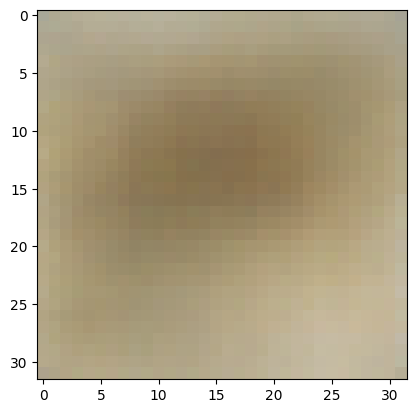

In [55]:
import matplotlib.pyplot as plt

plt.imshow(x_decoded[0])